#Day 6: Advanced Text Summarization with Hierarchical Attention and Multi-Modal Approaches

##Section 1: Dependency Installation & Imports


In [ ]:
!pip install transformers torch sentence-transformers scikit-learn networkx matplotlib seaborn evaluate --quiet

print("✅ Libraries installed successfully")

import torch
import torch.nn.functional as F
from transformers import BartForConditionalGeneration, BartTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
import warnings
import evaluate

warnings.filterwarnings('ignore')
print("✅ Libraries imported successfully")

✅ Libraries installed successfully
✅ Libraries imported successfully


## Section 2: Text Preprocessing and Sentence Splitting


In [ ]:

def clean_text(text):
    # Lowercase and remove unwanted characters except basic punctuation
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-z0-9.,!? ]', '', text)
    return text.strip()

def split_into_sentences(text):
    sentences = re.split(r'(?<=[.!?]) +', text)
    return [s.strip() for s in sentences if len(s.strip()) > 5]

# Example text
raw_text = """
Natural language processing (NLP) has made incredible advances, enabling machines to interpret and generate human language.
Deep learning architectures such as transformers have revolutionized how text is processed, leading to better summarization capabilities.
Graph-based methods and attention mechanisms capture context and relationships effectively.
Optimization across multiple objectives like coverage and readability is crucial for high-quality summaries.
Evaluating summarization techniques requires metrics such as ROUGE and semantic similarity measures.
"""

cleaned_text = clean_text(raw_text)
sentences = split_into_sentences(cleaned_text)

print(f"Total {len(sentences)} cleaned sentences:")
for i, sent in enumerate(sentences, 1):
    print(f"{i}. {sent}")

Total 5 cleaned sentences:
1. natural language processing nlp has made incredible advances, enabling machines to interpret and generate human language.
2. deep learning architectures such as transformers have revolutionized how text is processed, leading to better summarization capabilities.
3. graphbased methods and attention mechanisms capture context and relationships effectively.
4. optimization across multiple objectives like coverage and readability is crucial for highquality summaries.
5. evaluating summarization techniques requires metrics such as rouge and semantic similarity measures.


## Section 3: Sentence Importance Scoring Using Pretrained BART


In [ ]:
class SentenceScorer:
    def __init__(self):
        self.tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
        self.model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
        self.model.eval()
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        self.max_length = 512

    def score(self, sentences):
        scores = []
        for sentence in sentences:
            inputs = self.tokenizer.encode(sentence, max_length=self.max_length, truncation=True,
                                           padding='max_length', return_tensors='pt')
            with torch.no_grad():
                outputs = self.model(inputs, labels=inputs)
                loss = outputs.loss.item()
                scores.append(-loss)
        min_score, max_score = min(scores), max(scores)
        normalized_scores = [(s - min_score) / (max_score - min_score + 1e-8) for s in scores]
        return normalized_scores

# Initialize and score
scorer = SentenceScorer()
sentence_scores = scorer.score(sentences)
print("\nSentence Importance Scores (Normalized):")
for i, (sent, score) in enumerate(zip(sentences, sentence_scores), 1):
    print(f"{i}. Score: {score:.4f} | {sent}")


Sentence Importance Scores (Normalized):
1. Score: 0.7882 | natural language processing nlp has made incredible advances, enabling machines to interpret and generate human language.
2. Score: 1.0000 | deep learning architectures such as transformers have revolutionized how text is processed, leading to better summarization capabilities.
3. Score: 0.0000 | graphbased methods and attention mechanisms capture context and relationships effectively.
4. Score: 0.4152 | optimization across multiple objectives like coverage and readability is crucial for highquality summaries.
5. Score: 0.3192 | evaluating summarization techniques requires metrics such as rouge and semantic similarity measures.


## Section 4: Graph-based TextRank Summarization & Visualization





In [ ]:
class TextRankSummarizer:
    def __init__(self):
        self.embedder = SentenceTransformer('all-MiniLM-L6-v2')

    def build_similarity_graph(self, sentences, threshold=0.3):
        embeddings = self.embedder.encode(sentences)
        sim_matrix = cosine_similarity(embeddings)
        graph = nx.Graph()
        for i, sent in enumerate(sentences):
            graph.add_node(i, text=sent)
        for i in range(len(sentences)):
            for j in range(i+1, len(sentences)):
                if sim_matrix[i][j] > threshold:
                    graph.add_edge(i, j, weight=sim_matrix[i][j])
        return graph

    def rank_sentences(self, graph):
        return nx.pagerank(graph, weight='weight')

    def summarize(self, sentences, top_k=3):
        graph = self.build_similarity_graph(sentences)
        scores = self.rank_sentences(graph)
        ranked = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
        summary = [s for _, s in ranked[:top_k]]
        return summary

text_rank_summarizer = TextRankSummarizer()
text_rank_summary = text_rank_summarizer.summarize(sentences, top_k=3)

print("\nGraph-Based Extractive Summary:")
for sent in text_rank_summary:
    print("-", sent)


Graph-Based Extractive Summary:
- deep learning architectures such as transformers have revolutionized how text is processed, leading to better summarization capabilities.
- evaluating summarization techniques requires metrics such as rouge and semantic similarity measures.
- optimization across multiple objectives like coverage and readability is crucial for highquality summaries.


## Section 5: Multi-Objective Summary Optimization




In [ ]:
class MultiObjectiveOptimizer:
    def __init__(self):
        self.embedder = SentenceTransformer('all-MiniLM-L6-v2')

    def semantic_coverage(self, summary, original):
        sim_s = self.embedder.encode([summary])
        sim_o = self.embedder.encode([original])
        return cosine_similarity(sim_s, sim_o)[0][0]

    def readability(self, text):
        sents = [s.strip() for s in text.split('.') if s.strip()]
        if not sents:
            return 0.5
        avg_len = np.mean([len(s.split()) for s in sents])
        if 15 <= avg_len <= 20:
            return 1.0
        else:
            diff = min(abs(avg_len-15), abs(avg_len-20))
            return max(0, 1 - diff/10)

    def coherence(self, sents):
        if len(sents) < 2:
            return 1.0
        embeddings = self.embedder.encode(sents)
        sims = [cosine_similarity([embeddings[i]], [embeddings[i+1]])[0][0] for i in range(len(sents)-1)]
        return np.mean(sims)

    def diversity(self, sents):
        if len(sents) < 2:
            return 1.0
        embeddings = self.embedder.encode(sents)
        sim_matrix = cosine_similarity(embeddings)
        upper = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]
        return max(0, 1 - np.mean(upper))

    def optimize(self, original_text, candidate_summaries):
        results = []
        for summary in candidate_summaries:
            if isinstance(summary, list):
                summary_text = " ".join(summary)
                sents = summary
            else:
                summary_text = summary
                sents = [s.strip() for s in summary_text.split('.') if s.strip()]
            coverage = self.semantic_coverage(summary_text, original_text)
            readability = self.readability(summary_text)
            coherence = self.coherence(sents)
            diversity = self.diversity(sents)
            combined_score = 0.4*coverage + 0.2*readability + 0.25*coherence + 0.15*diversity
            results.append({
                'summary': summary_text,
                'score': combined_score,
                'coverage': coverage,
                'readability': readability,
                'coherence': coherence,
                'diversity': diversity
            })
        results.sort(key=lambda x: x['score'], reverse=True)
        return results

optimizer = MultiObjectiveOptimizer()
candidate_summaries = [text_rank_summary, sentences[:3], raw_text]
optimization_results = optimizer.optimize(cleaned_text, candidate_summaries)

print("\nMulti-Objective Optimization Results:")
for i, res in enumerate(optimization_results):
    print(f"\nRank {i+1} with Score: {res['score']:.3f}")
    print(res['summary'])


Multi-Objective Optimization Results:

Rank 1 with Score: 0.759

Natural language processing (NLP) has made incredible advances, enabling machines to interpret and generate human language.
Deep learning architectures such as transformers have revolutionized how text is processed, leading to better summarization capabilities.
Graph-based methods and attention mechanisms capture context and relationships effectively.
Optimization across multiple objectives like coverage and readability is crucial for high-quality summaries.
Evaluating summarization techniques requires metrics such as ROUGE and semantic similarity measures.


Rank 2 with Score: 0.748
natural language processing nlp has made incredible advances, enabling machines to interpret and generate human language. deep learning architectures such as transformers have revolutionized how text is processed, leading to better summarization capabilities. graphbased methods and attention mechanisms capture context and relationships effec

## Section 6: Summary Evaluation (ROUGE-1 and Semantic Similarity)




In [ ]:
class SummaryEvaluator:
    def __init__(self):
        self.embedder = SentenceTransformer('all-MiniLM-L6-v2')
        self.rouge = evaluate.load("rouge")

    def rouge_scores(self, generated, reference):
        results = self.rouge.compute(predictions=[generated], references=[reference])
        return {
            'rouge1': results['rouge1'],
            'rouge2': results['rouge2'],
            'rougeL': results['rougeL']
        }

    def semantic_similarity(self, gen, ref):
        gen_emb = self.embedder.encode([gen])
        ref_emb = self.embedder.encode([ref])
        return cosine_similarity(gen_emb, ref_emb)[0][0]

    def evaluate(self, generated_summary, reference_summary):
        rouge_res = self.rouge_scores(generated_summary, reference_summary)
        sem_sim = self.semantic_similarity(generated_summary, reference_summary)
        return {
            "rouge-1": rouge_res.get("rouge1", 0),
            "rouge-2": rouge_res.get("rouge2", 0),
            "rouge-l": rouge_res.get("rougeL", 0),
            "semantic_similarity": sem_sim
        }

evaluator = SummaryEvaluator()
reference_summary = """
Natural language processing enables machines to understand text. Deep learning transformer models enable better summarization.
"""
best_summary = optimization_results[0]['summary']
eval_results = evaluator.evaluate(best_summary, reference_summary)
print("\nSummary Evaluation:")
print(eval_results)


Summary Evaluation:
{'rouge-1': np.float64(0.23529411764705882), 'rouge-2': np.float64(0.12048192771084339), 'rouge-l': np.float64(0.21176470588235294), 'semantic_similarity': np.float32(0.7550419)}


## Sentence Similarity Heatmap Visualization

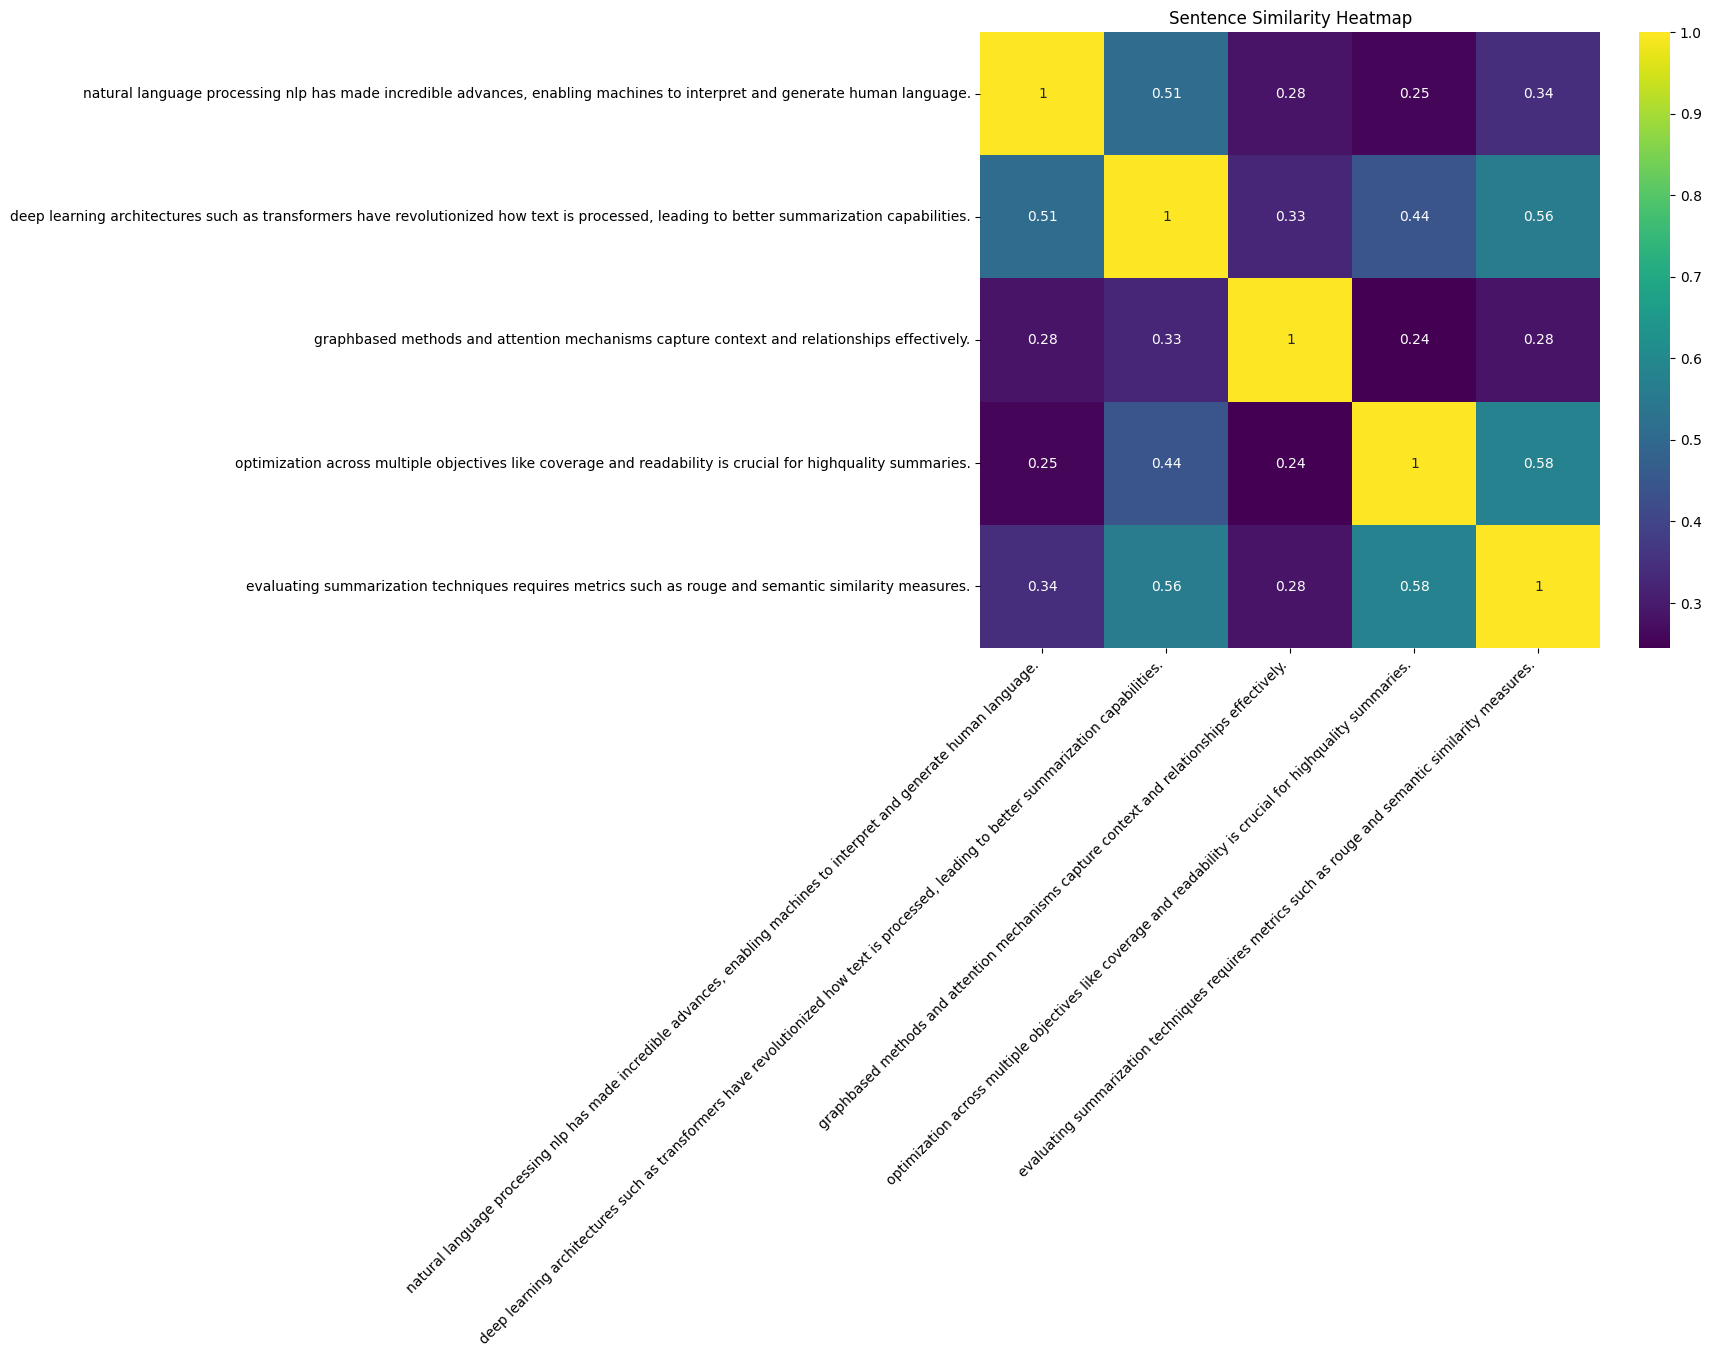

In [ ]:
def plot_similarity_heatmap(sentences, embedder):
    embeddings = embedder.encode(sentences)
    sim_matrix = cosine_similarity(embeddings)
    plt.figure(figsize=(10,8))
    sns.heatmap(sim_matrix, xticklabels=sentences, yticklabels=sentences, cmap='viridis', annot=True)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.title("Sentence Similarity Heatmap")
    plt.tight_layout()
    plt.show()

plot_similarity_heatmap(sentences, text_rank_summarizer.embedder)


## Sentence Embedding Clustering with t-SNE Visualization

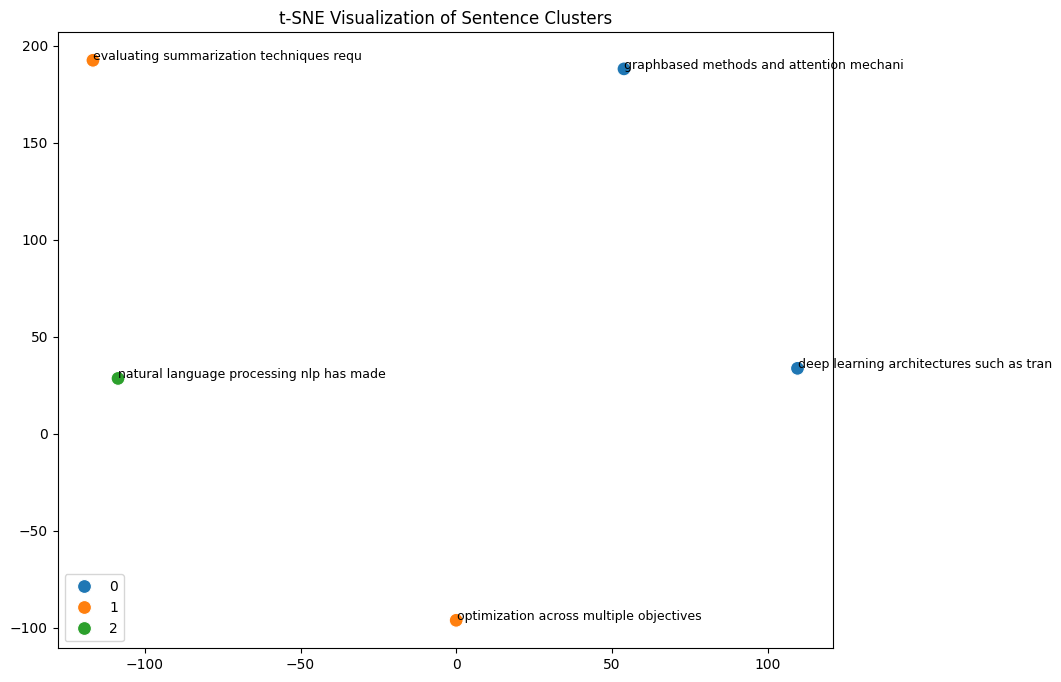

Cluster labels: [2 0 0 1 1]


In [ ]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

def cluster_and_visualize(sentences, embedder, n_clusters=3):
    embeddings = embedder.encode(sentences)
    kmeans = KMeans(n_clusters=min(n_clusters, len(sentences)), random_state=42).fit(embeddings)

    perplexity = min(5, len(sentences)-1)  # Set perplexity < n_samples
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    tsne_proj = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=tsne_proj[:,0], y=tsne_proj[:,1], hue=kmeans.labels_, palette='tab10', s=100)
    for i, sentence in enumerate(sentences):
        plt.text(tsne_proj[i,0]+0.1, tsne_proj[i,1], sentence[:40], fontsize=9)
    plt.title("t-SNE Visualization of Sentence Clusters")
    plt.show()

    return kmeans.labels_


cluster_labels = cluster_and_visualize(sentences, text_rank_summarizer.embedder)
print("Cluster labels:", cluster_labels)


## Experimenting with TextRank Thresholds

In [ ]:
def summarize_with_thresholds(sentences, thresholds=[0.1, 0.3, 0.5], top_k=3):
    for thr in thresholds:
        print(f"\nTextRank Summary with threshold {thr}:")
        graph = text_rank_summarizer.build_similarity_graph(sentences, threshold=thr)
        scores = text_rank_summarizer.rank_sentences(graph)
        ranked = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
        for _, s in ranked[:top_k]:
            print("-", s)

summarize_with_thresholds(sentences)



TextRank Summary with threshold 0.1:
- deep learning architectures such as transformers have revolutionized how text is processed, leading to better summarization capabilities.
- evaluating summarization techniques requires metrics such as rouge and semantic similarity measures.
- optimization across multiple objectives like coverage and readability is crucial for highquality summaries.

TextRank Summary with threshold 0.3:
- deep learning architectures such as transformers have revolutionized how text is processed, leading to better summarization capabilities.
- evaluating summarization techniques requires metrics such as rouge and semantic similarity measures.
- optimization across multiple objectives like coverage and readability is crucial for highquality summaries.

TextRank Summary with threshold 0.5:
- evaluating summarization techniques requires metrics such as rouge and semantic similarity measures.
- deep learning architectures such as transformers have revolutionized how te

## Extended Multi-Objective Scoring with Novelty & Compression Ratio

In [ ]:
def compression_ratio(summary, original):
    return len(summary.split()) / len(original.split())

class ExtendedMultiObjectiveOptimizer(MultiObjectiveOptimizer):
    def novelty(self, summary):
        sents = [s.strip() for s in summary.split('.') if s.strip()]
        embeddings = self.embedder.encode(sents)
        sim_matrix = cosine_similarity(embeddings)
        return 1 - np.mean(sim_matrix[np.triu_indices_from(sim_matrix, k=1)]) if len(sents) > 1 else 1.0

    def optimize(self, original_text, candidate_summaries):
        results = []
        for summary in candidate_summaries:
            summary_text = " ".join(summary) if isinstance(summary, list) else summary
            coverage = self.semantic_coverage(summary_text, original_text)
            readability = self.readability(summary_text)
            coherence = self.coherence([s.strip() for s in summary_text.split('.') if s.strip()])
            diversity = self.diversity([s.strip() for s in summary_text.split('.') if s.strip()])
            novelty = self.novelty(summary_text)
            compress = compression_ratio(summary_text, original_text)
            combined_score = (
                0.35*coverage + 0.2*readability + 0.15*coherence + 0.1*diversity + 0.1*novelty + 0.1*(1-compress)
            )
            results.append({
                'summary': summary_text,
                'score': combined_score,
                'coverage': coverage,
                'readability': readability,
                'coherence': coherence,
                'diversity': diversity,
                'novelty': novelty,
                'compression_ratio': compress
            })
        results.sort(key=lambda x: x['score'], reverse=True)
        return results

ext_optimizer = ExtendedMultiObjectiveOptimizer()
ext_results = ext_optimizer.optimize(cleaned_text, candidate_summaries)

print("\nExtended Multi-Objective Optimization Results:")
for i, r in enumerate(ext_results):
    print(f"Rank {i+1} Score: {r['score']:.3f}")
    print(r['summary'])
    print("Metrics:", {k: v for k, v in r.items() if k != 'summary'})



Extended Multi-Objective Optimization Results:
Rank 1 Score: 0.729
natural language processing nlp has made incredible advances, enabling machines to interpret and generate human language. deep learning architectures such as transformers have revolutionized how text is processed, leading to better summarization capabilities. graphbased methods and attention mechanisms capture context and relationships effectively.
Metrics: {'score': np.float64(0.7287819213230236), 'coverage': np.float32(0.90725875), 'readability': np.float64(0.9333333333333333), 'coherence': np.float32(0.41234535), 'diversity': np.float32(0.6297909), 'novelty': np.float32(0.6297909), 'compression_ratio': 0.6323529411764706}
Rank 2 Score: 0.706
deep learning architectures such as transformers have revolutionized how text is processed, leading to better summarization capabilities. evaluating summarization techniques requires metrics such as rouge and semantic similarity measures. optimization across multiple objectives 

## Embedding Similarity as Proxy for Human Evaluation

In [ ]:
candidate_summary = ext_results[0]['summary']
reference_summary = reference_summary if 'reference_summary' in globals() else raw_text

similarity_score = text_rank_summarizer.embedder.encode([candidate_summary, reference_summary])
similarity = cosine_similarity([similarity_score[0]], [similarity_score[1]])[0][0]
print(f"Embedding-based similarity (proxy for human eval): {similarity:.3f}")


Embedding-based similarity (proxy for human eval): 0.788
